In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.plot_functions import *

In [2]:
resultados = {
              "Baseline": load__preds("delight_baseline_r"),
              #"Baseline sampler 2 bins": load__preds("delight_baseline_sampler_2bins"),
              #"Baseline sampler 5 bins": load__preds("delight_baseline_sampler_5bins"),

              "Pasquet": load__preds("pasquet_augmented_002_percent"),
              "Pasquet sampler": load__preds("pasquet_augmented_002_percent_sampler"),
              "Pasquet 512": load__preds("pasquet_augmented_002_percent_512"),
              "Pasquet 512 sampler": load__preds("pasquet_augmented_002_percent_sampler_512"),

              "Baseline sampler 30": load__preds("delight_baseline_sampler_30"),
              "Baseline sampler 30": load__preds("delight_baseline_sampler_30"),
              "Baseline sampler 30": load__preds("delight_baseline_sampler_30"),

              "Baseline sampler 30": load__preds("delight_baseline_sampler_30"),
              "Baseline sampler 40": load__preds("delight_baseline_sampler_40"),
              "Baseline sampler 50": load__preds("delight_baseline_sampler_50"),

              "Autolabeling 1% 1": load__preds("delight_augmented_1_percent_1"),
              "Autolabeling 1% 2": load__preds("delight_augmented_1_percent_2"),
              "Autolabeling 1% 3": load__preds("delight_augmented_1_percent_3"),

              "Autolabeling sampler 1% 1": load__preds("delight_augmented_1_percent_1_sampler"),
              "Autolabeling sampler 1% 2": load__preds("delight_augmented_1_percent_2_sampler"),
              "Autolabeling sampler 1% 3": load__preds("delight_augmented_1_percent_3_sampler"),
              
              "Autolabeling 05% 1": load__preds("delight_augmented_05_percent_1"),
              "Autolabeling 05% 2": load__preds("delight_augmented_05_percent_2"),
              "Autolabeling 05% 3": load__preds("delight_augmented_05_percent_3"),

              "Autolabeling sampler 05% 1": load__preds("delight_augmented_05_percent_1_sampler"),
              "Autolabeling sampler 05% 2": load__preds("delight_augmented_05_percent_2_sampler"),
              "Autolabeling sampler 05% 3": load__preds("delight_augmented_05_percent_3_sampler"),


              "Autolabeling 01% 1": load__preds("delight_augmented_01_percent_1"),
              "Autolabeling 01% 2": load__preds("delight_augmented_01_percent_2"),
              "Autolabeling 01% 3": load__preds("delight_augmented_01_percent_3"),

              "Autolabeling sampler 01% 1": load__preds("delight_augmented_01_percent_1_sampler"),
              "Autolabeling sampler 01% 2": load__preds("delight_augmented_01_percent_2_sampler"),
              "Autolabeling sampler 01% 3": load__preds("delight_augmented_01_percent_3_sampler"),

              }

### Pasquet

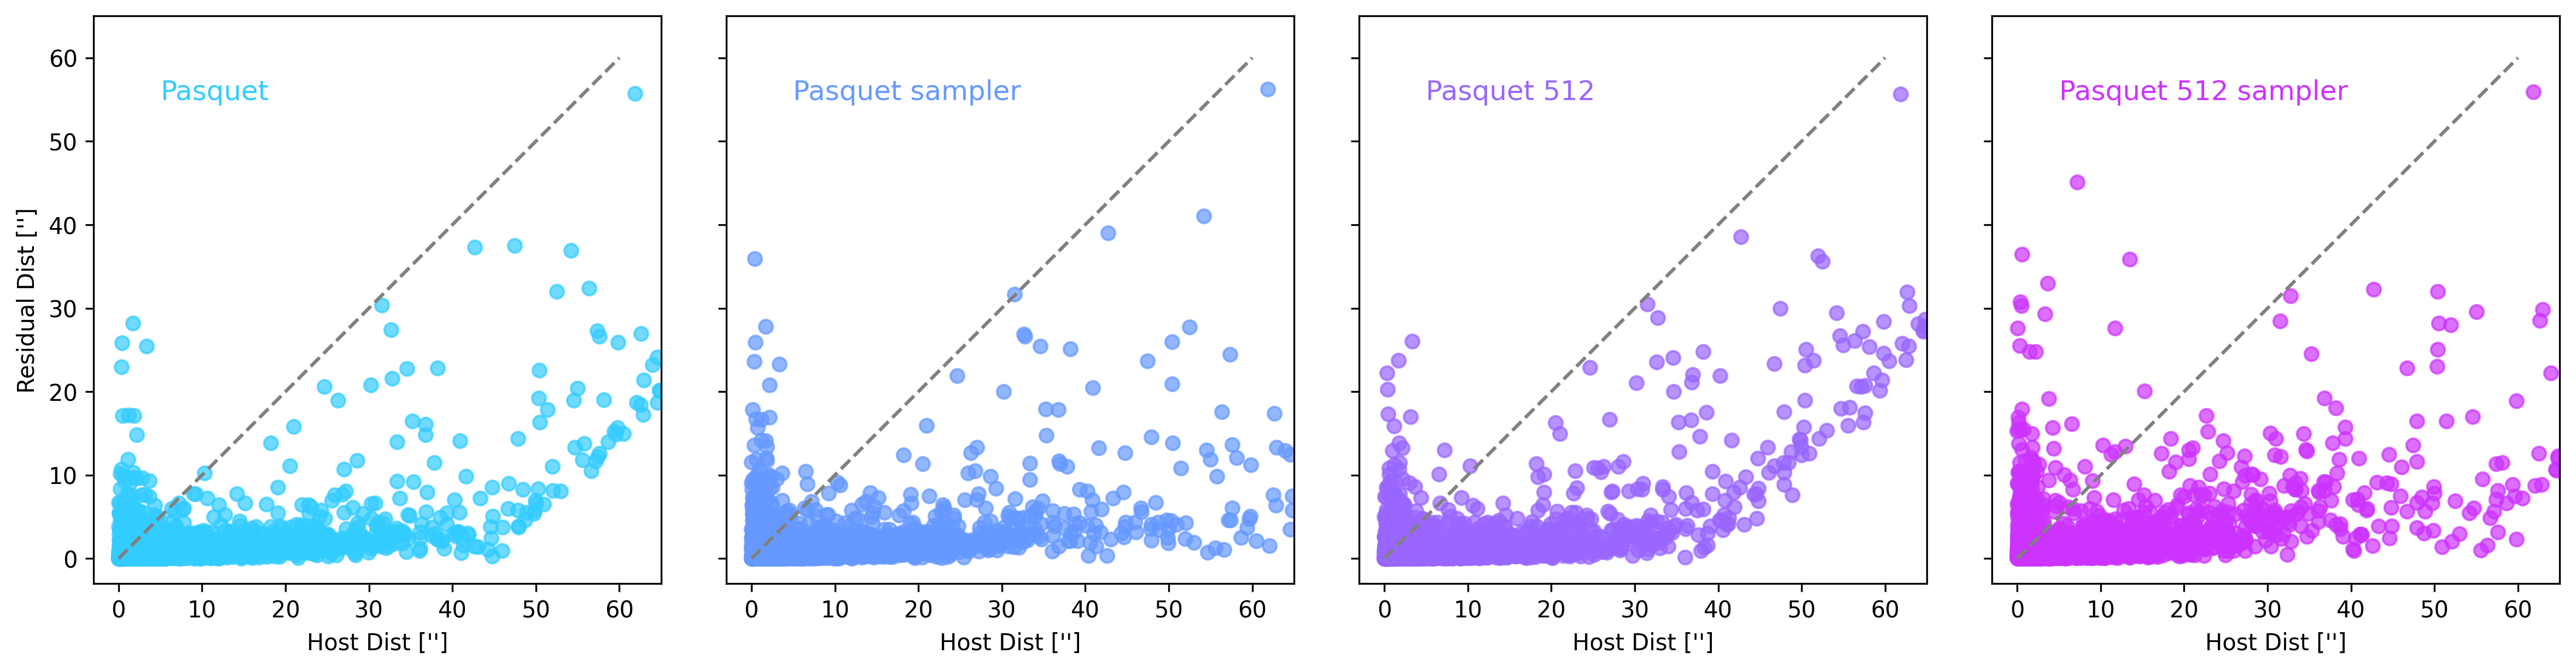

In [4]:
plot_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Pasquet"],
                                                     ["Pasquet sampler"],
                                                    ["Pasquet 512"],                                             
                                                     ["Pasquet 512 sampler"]],                                             

                                        titles = ["Pasquet","Pasquet sampler","Pasquet 512", "Pasquet 512 sampler"],
                                        cmap_name ="cool",
                                        dpi=300)

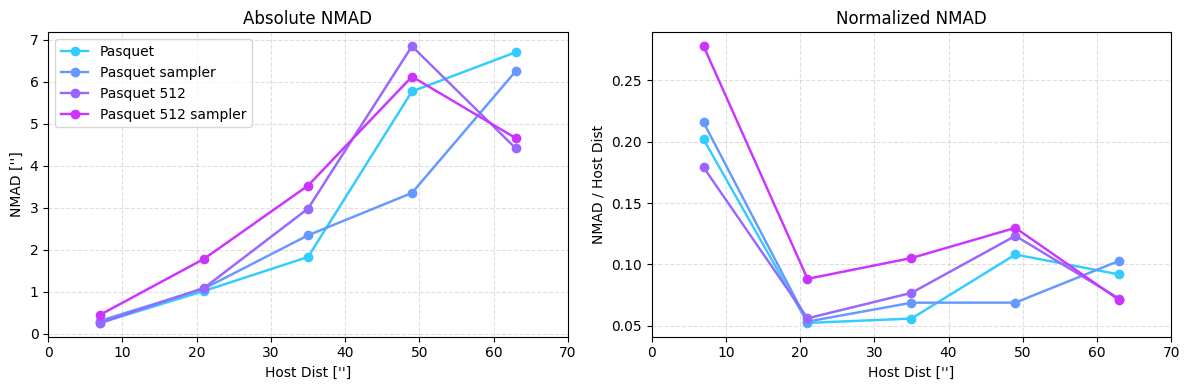

In [4]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Pasquet"],
                                                     ["Pasquet sampler"],
                                                    ["Pasquet 512"],                                             
                                                     ["Pasquet 512 sampler"]],                                             

                                        titles = ["Pasquet","Pasquet sampler","Pasquet 512", "Pasquet 512 sampler"],
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        dpi=100)

### Samplers

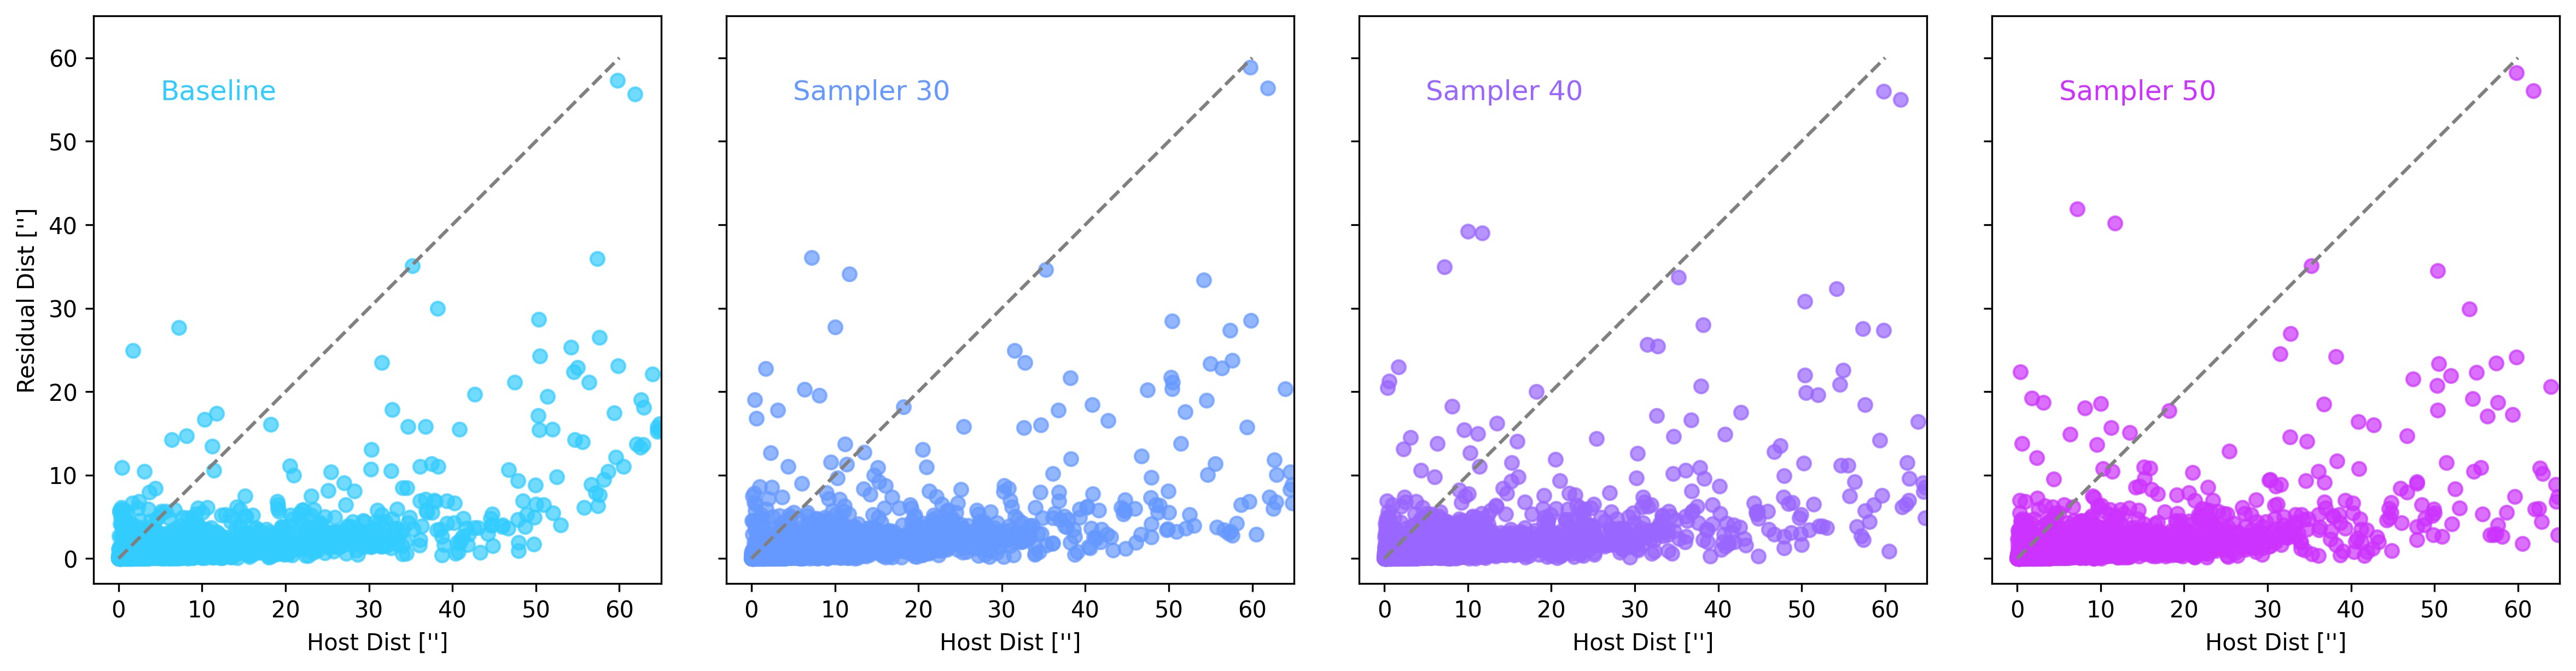

In [2]:
plot_residuals_vs_host_dist(resultados, experiments=["Baseline","Baseline sampler 30","Baseline sampler 40","Baseline sampler 50"],                                              
                                        titles = ["Baseline","Sampler 30","Sampler 40","Sampler 50"],
                                        cmap_name ="cool",
                                        dpi=300)

/tmp/ipykernel_1344393/2320267234.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


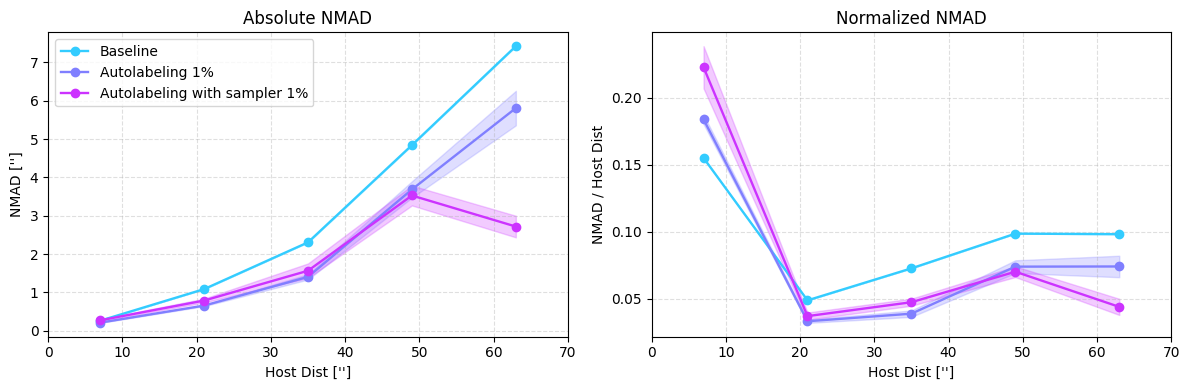

In [22]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Baseline"],
                                                     ["Autolabeling 1% 1","Autolabeling 1% 2","Autolabeling 1% 3"],
                                                     ["Autolabeling sampler 1% 1","Autolabeling sampler 1% 2","Autolabeling sampler 1% 3"]],                                             
                                        titles = ["Baseline","Autolabeling 1%","Autolabeling with sampler 1%"],
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        dpi=100)

### DELIGHT DATASET

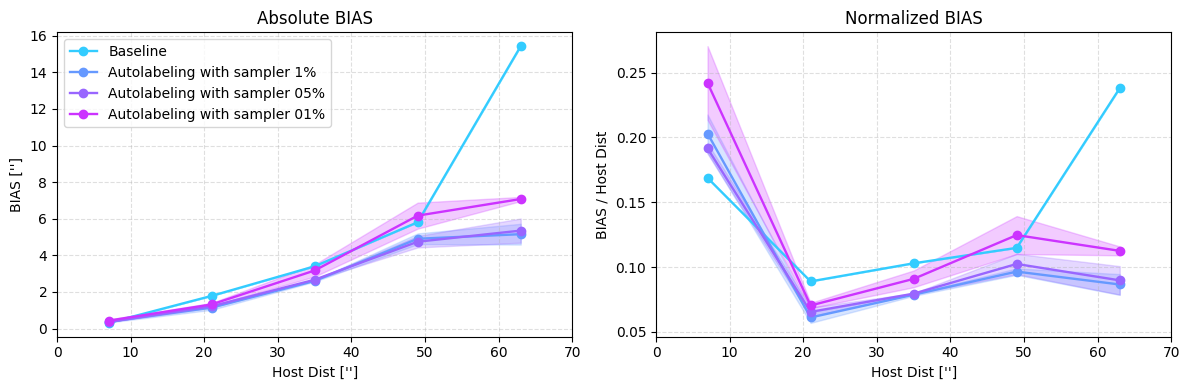

In [3]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Baseline"],
                                                     ["Autolabeling sampler 1% 1","Autolabeling sampler 1% 2","Autolabeling sampler 1% 3"],
                                                    ["Autolabeling sampler 05% 1","Autolabeling sampler 05% 2","Autolabeling sampler 05% 3"],                                             
                                                     ["Autolabeling sampler 01% 1","Autolabeling sampler 01% 2","Autolabeling sampler 01% 3"]],                                             

                                        titles = ["Baseline","Autolabeling with sampler 1%","Autolabeling with sampler 05%", "Autolabeling with sampler 01%"],
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="bias",
                                        dpi=100)

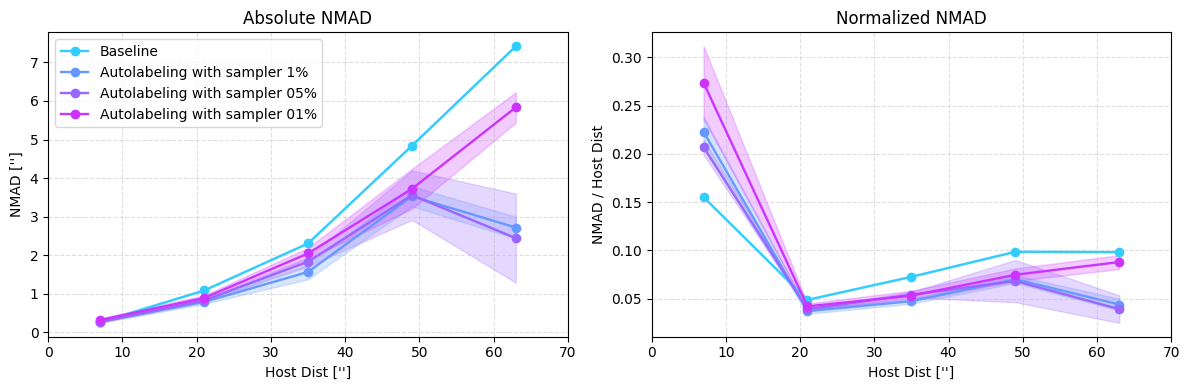

In [14]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Baseline"],
                                                     ["Autolabeling sampler 1% 1","Autolabeling sampler 1% 2","Autolabeling sampler 1% 3"],
                                                    ["Autolabeling sampler 05% 1","Autolabeling sampler 05% 2","Autolabeling sampler 05% 3"],                                             
                                                     ["Autolabeling sampler 01% 1","Autolabeling sampler 01% 2","Autolabeling sampler 01% 3"]],                                             

                                        titles = ["Baseline","Autolabeling with sampler 1%","Autolabeling with sampler 05%", "Autolabeling with sampler 01%"],
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        dpi=100)

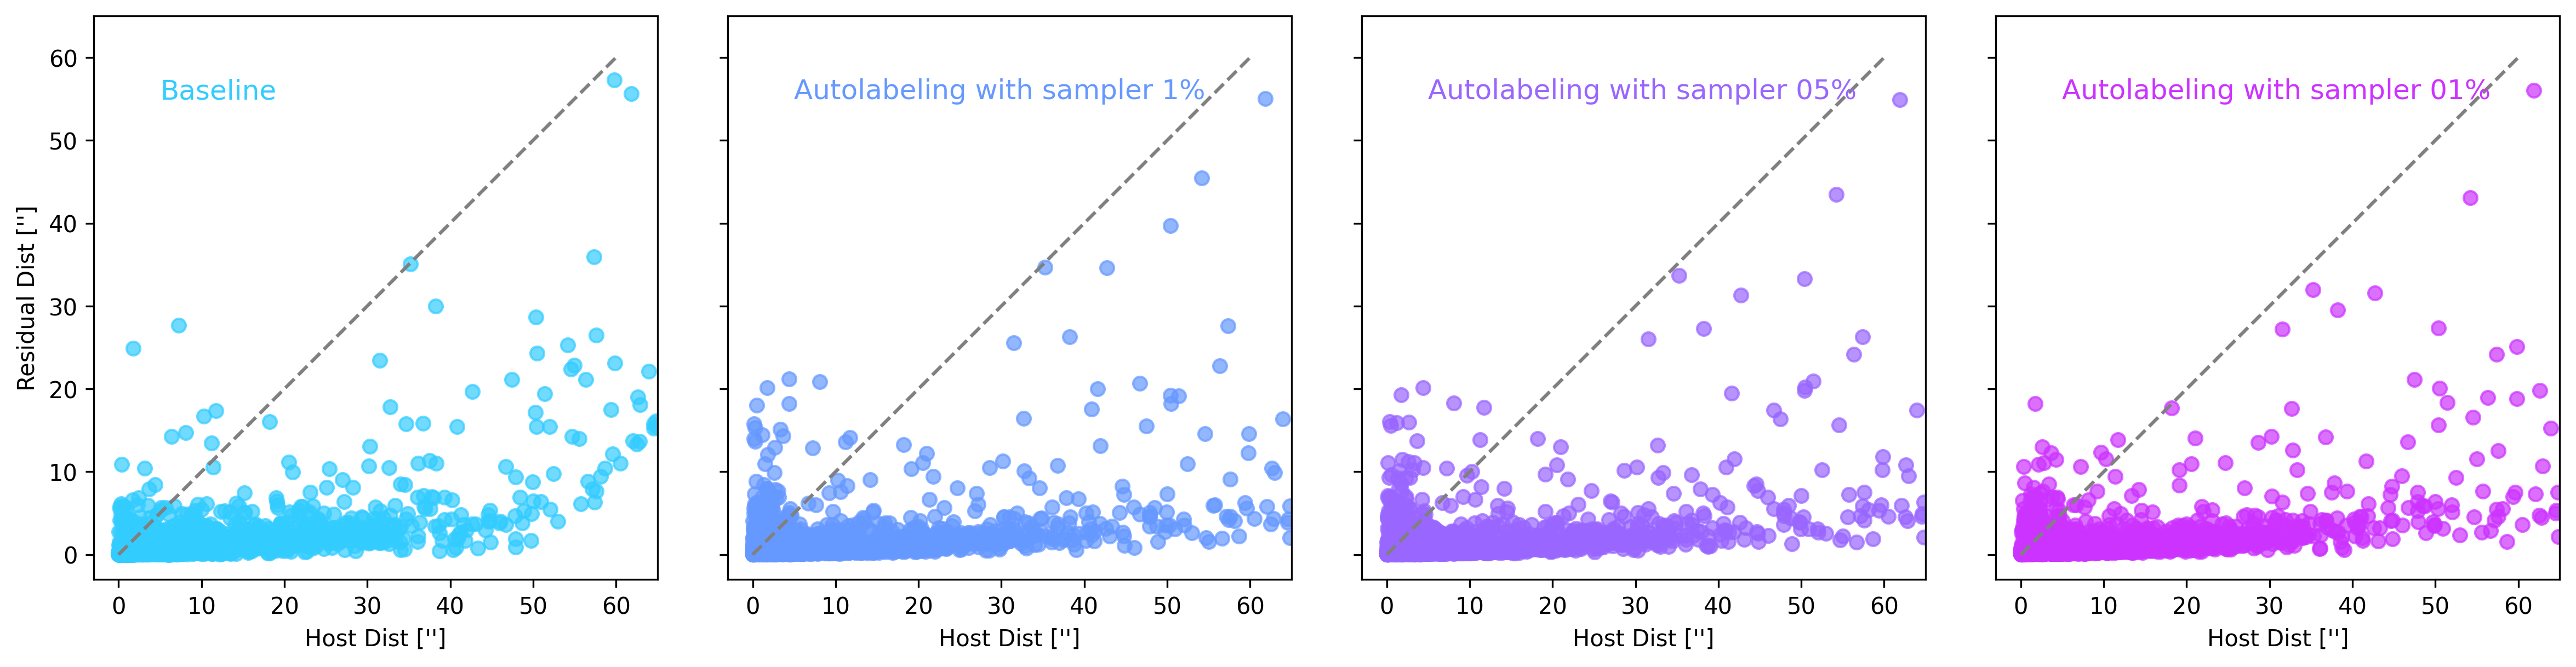

In [5]:
plot_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=[["Baseline"],
                                                     ["Autolabeling sampler 1% 1","Autolabeling sampler 1% 2","Autolabeling sampler 1% 3"],
                                                    ["Autolabeling sampler 05% 1","Autolabeling sampler 05% 2","Autolabeling sampler 05% 3"],                                             
                                                     ["Autolabeling sampler 01% 1","Autolabeling sampler 01% 2","Autolabeling sampler 01% 3"]],                                             

                                        titles = ["Baseline","Autolabeling with sampler 1%","Autolabeling with sampler 05%", "Autolabeling with sampler 01%"],
                                        cmap_name ="cool",
                                        dpi=300)

In [4]:
for title, _ in resultados.items():
    print(title.upper())
    print_metrics(resultados, title)
    print("")

BASELINE
RMSE: 2.1804518699645996
mean deviation: 0.9844095706939697
median deviation: 0.3530474007129669
mode deviation: 0.7754042148590088

BASELINE SAMPLER 30
RMSE: 2.273097276687622
mean deviation: 1.0657124519348145
median deviation: 0.39605745673179626
mode deviation: 0.38864418864250183

BASELINE SAMPLER 40
RMSE: 2.274545669555664
mean deviation: 1.0614014863967896
median deviation: 0.38034069538116455
mode deviation: 0.2126009613275528

BASELINE SAMPLER 50
RMSE: 2.2498881816864014
mean deviation: 1.0539813041687012
median deviation: 0.39783474802970886
mode deviation: 0.05434813350439072

AUTOLABELING 1%
RMSE: 2.0388295650482178
mean deviation: 0.8247356414794922
median deviation: 0.3312215209007263
mode deviation: 0.8171874284744263

AUTOLABELING 05%
RMSE: 1.9834237098693848
mean deviation: 0.8213157653808594
median deviation: 0.3434351980686188
mode deviation: 1.1320602893829346

AUTOLABELING 01%
RMSE: 2.091874837875366
mean deviation: 0.9095228314399719
median deviation: 0.3